# Suivi de la dynamique des eaux de surface en Afrique de l'ouest

* **Products used:** 
[wofs_ls_summary_alltime](https://explorer.digitalearth.africa/wofs_ls_summary_alltime)

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd

from geopy.geocoders import Nominatim 
from IPython.display import Image
from matplotlib.colors import ListedColormap
import seaborn as sns
from matplotlib.patches import Patch
from deafrica_tools.spatial import subpixel_contours
from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import display_map, xr_animation, map_shapefile, rgb
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.spatial import xr_rasterize
from deafrica_tools.coastal import tidal_tag
from odc.ui import image_aspect
from datacube.utils import geometry
from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=True, cloud_defaults=True)
from deafrica_tools.datahandling import wofs_fuser

In [2]:
dc = datacube.Datacube(app='Suivi de la dynamique des eaux de surface')

In [3]:
create_local_dask_cluster()

/env/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37291 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:36517 Dashboard: /user/ndeye.fatou.sane28@gmail.com/proxy/37291/status,Cluster Workers: 1 Cores: 4 Memory: 28.14 GB


In [4]:
site = "Lac Rose ,Sénégal "

In [5]:
app = Nominatim(user_agent="JournalDev")
location = app.geocode(site).raw

In [6]:
lat = float(pd.DataFrame(location).lat[0])
lon = float(pd.DataFrame(location).lon[0])

lat_buffer = 0.02
lon_buffer = 0.035

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

# Define the start year and end year
#start_year = '2017'
#end_year = '2022'
time_range = ("2019","2022") #"2018",

In [7]:
display_map(lon_range, lat_range)

In [8]:
query = {
    'x': lon_range,
    'y': lat_range,
    'resolution': (-20, 20),
    'output_crs':'EPSG:6933',
    "group_by": "solar_day",
    'time': "2020",
    'dask_chunks':{'time':1,'x':500,'y':500}
    }
S1 = load_ard(dc=dc,
              products=["s1_rtc"],
              measurements=['vv', 'vh'],
              dtype='native',
              **query)

print(S1)

S2 = load_ard(dc=dc,
             products=['s2_l2a'],
             measurements=['green','swir_1','nir', 'red', 'blue', 'swir_2'],
             mask_filters=[("opening", 3),("dilation", 2)], 
             **query)
query = {
    'x': lon_range,
    'y': lat_range,
    'resolution': (-30, 30),
    'output_crs':'EPSG:6933',
    'time': time_range,
}

#load wofs
Wofs = dc.load(product="wofs_ls_summary_annual",
             **query)

print(Wofs)



Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Returning 31 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 31, y: 248, x: 339)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-04T19:18:24.081937 ... 2020-12...
  * y            (y) float64 1.876e+06 1.876e+06 ... 1.871e+06 1.871e+06
  * x            (x) float64 -1.665e+06 -1.665e+06 ... -1.658e+06 -1.658e+06
    spatial_ref  int32 6933
Data variables:
    vv           (time, y, x) float32 dask.array<chunksize=(1, 248, 339), meta=np.ndarray>
    vh           (time, y, x) float32 dask.array<chunksize=(1, 248, 339), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref
Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying morphological filters to pq mask [('opening', 3), ('dilation', 2)]
Applying pixel quality/cloud mask
Returning 73 time steps as a dask array
<xarray.Dataset>
Dimensio

In [9]:
pixel_length = query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

In [10]:
water_threshold = 0.20
#threshold
Wofs_water = Wofs.frequency > water_threshold

#calculate are
Wofs_extent = Wofs_water.sum(dim=['x', 'y']) * area_per_pixel
Wofs_extent

<xarray.DataArray 'frequency' (time: 3)>
array([6.6114, 7.0119, 6.9948])
Coordinates:
  * time         (time) datetime64[ns] 2019-07-02T11:59:59.999999 ... 2021-07...
    spatial_ref  int32 6933

<Figure size 1296x288 with 0 Axes>

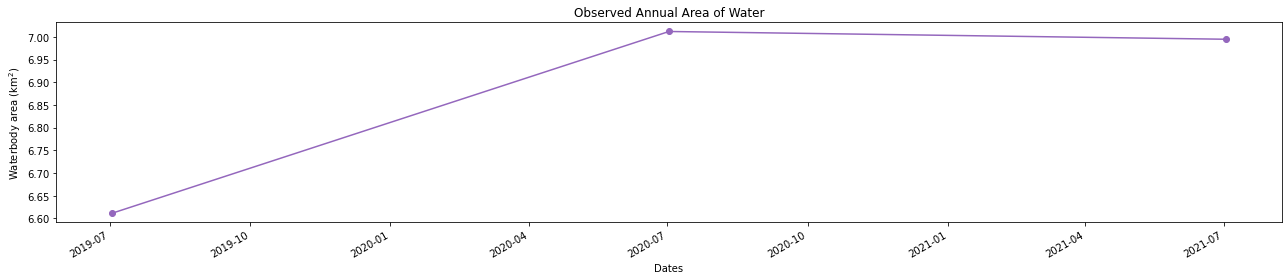

In [11]:
plt.figure(figsize=(18, 4))
plt.figure(figsize=(18, 4))
Wofs_extent.plot(marker='o', color='#9467bd')
plt.title(f'Observed Annual Area of Water')
plt.xlabel('Dates')
plt.ylabel('Waterbody area (km$^2$)')
plt.tight_layout()

In [12]:
min_Wofs_extent_date, max_Wofs_extent_date =  min(Wofs_extent), max(Wofs_extent)
time_xr = xr.DataArray([min_Wofs_extent_date.time.values, max_Wofs_extent_date.time.values], dims=["time"])

print(time_xr)

<xarray.DataArray (time: 2)>
array(['2019-07-02T11:59:59.999999000', '2020-07-01T23:59:59.999999000'],
      dtype='datetime64[ns]')
Dimensions without coordinates: time


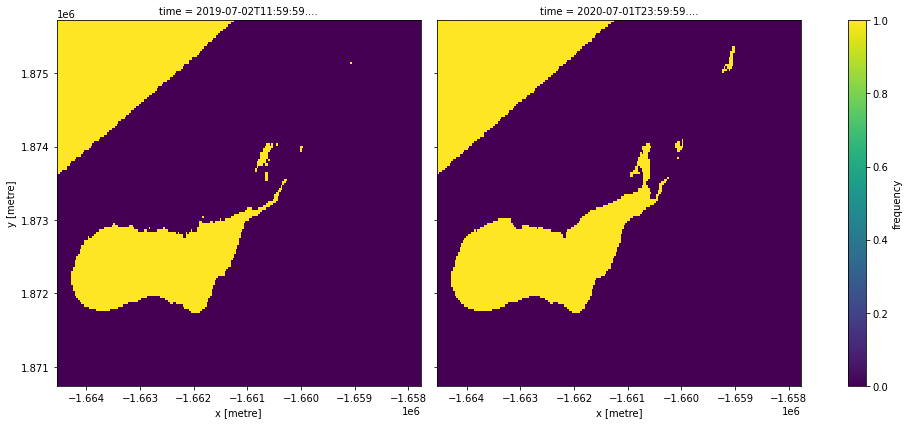

In [13]:
Wofs_water.sel(time=time_xr).plot.imshow(col="time", col_wrap=2, figsize=(14, 6));

In [14]:
baseline_time = '2020'
analysis_time = '2022'

baseline_ds, analysis_ds = Wofs_extent.sel(time=baseline_time, method ='nearest'), Wofs_extent.sel(time=analysis_time, method ='nearest')

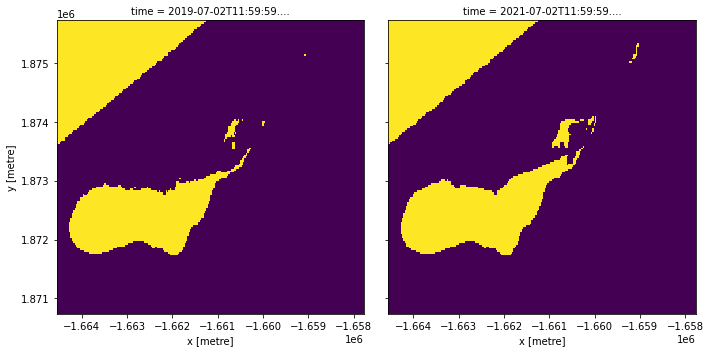

In [15]:
compare = Wofs_water.sel(time=[baseline_ds.time.values, analysis_ds.time.values])
compare.plot(col='time',col_wrap=2,figsize=(10, 5), cmap='viridis', add_colorbar=False);

In [16]:
analyse_total_value = compare.isel(time=1).astype(int)
change = analyse_total_value - compare.isel(time=0).astype(int)

water_appeared = change.where(change == 1)
permanent_water = change.where((change == 0) & (analyse_total_value == 1))
permanent_land = change.where((change == 0) & (analyse_total_value == 0))
water_disappeared = change.where(change == -1)

In [17]:
total_area = analyse_total_value.count().values * area_per_pixel
water_apperaed_area = water_appeared.count().values * area_per_pixel
permanent_water_area = permanent_water.count().values * area_per_pixel
water_disappeared_area = water_disappeared.count().values * area_per_pixel

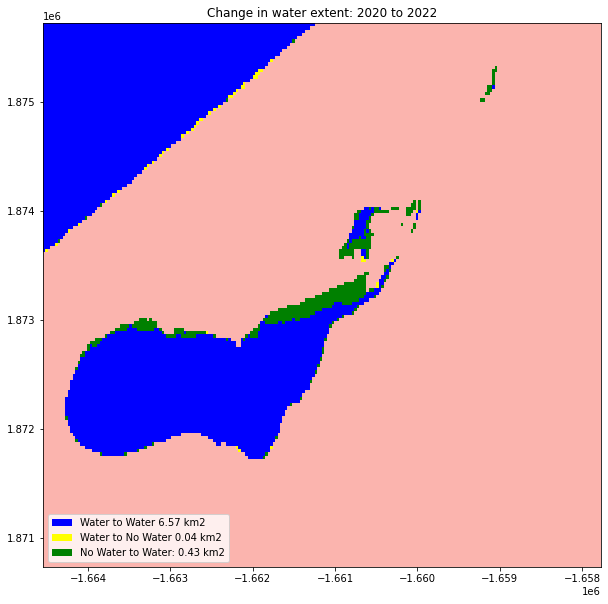

In [18]:
water_appeared_color = "Green"
water_disappeared_color = "Yellow"
stable_color = "Blue"
land_color = "Brown"

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

compare[1].plot.imshow(cmap="Pastel1",
                                       add_colorbar=False,
                                       add_labels=False,
                                       ax=ax)
water_appeared.plot.imshow(
    cmap=ListedColormap([water_appeared_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)
water_disappeared.plot.imshow(
    cmap=ListedColormap([water_disappeared_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)
permanent_water.plot.imshow(cmap=ListedColormap([stable_color]),
                            add_colorbar=False,
                            add_labels=False,
                            ax=ax)

plt.legend(
    [
        Patch(facecolor=stable_color),
        Patch(facecolor=water_disappeared_color),
        Patch(facecolor=water_appeared_color),
        Patch(facecolor=land_color),
    ],
    [
        f"Water to Water {round(permanent_water_area, 2)} km2",
        f"Water to No Water {round(water_disappeared_area, 2)} km2",
        f"No Water to Water: {round(water_apperaed_area, 2)} km2",
    ],
    loc="lower left",
)

plt.title("Change in water extent: " + baseline_time + " to " + analysis_time);

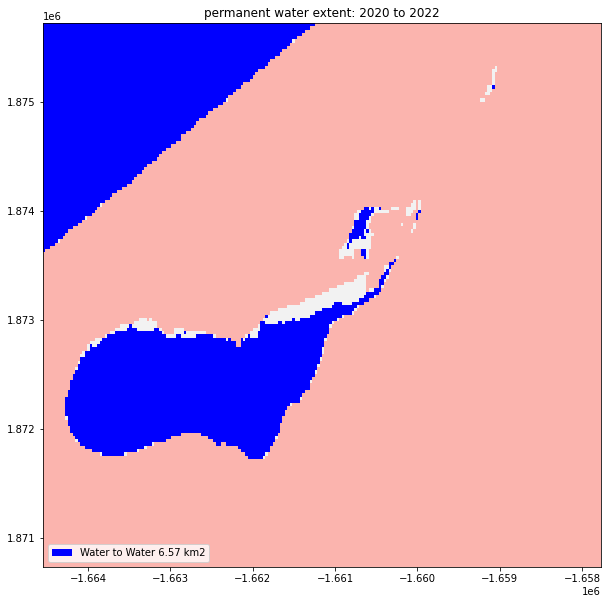

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

compare[1].plot.imshow(cmap="Pastel1",
                                       add_colorbar=False,
                                       add_labels=False,
                                       ax=ax)
permanent_water.plot.imshow(cmap=ListedColormap([stable_color]),
                            add_colorbar=False,
                            add_labels=False,
                            ax=ax)
plt.legend(
    [ Patch(facecolor=stable_color),],
    [f"Water to Water {round(permanent_water_area, 2)} km2"],
    loc="lower left",
)

plt.title("permanent water extent: " + baseline_time + " to " + analysis_time);

In [20]:
# Convert DN to db values.
S1["vv_db"] = 10 * xr.ufuncs.log10(S1.vv)
S1["vh_db"] = 10 * xr.ufuncs.log10(S1.vh)
# Calculate the Sentinel-1A Water Index (SWI).
S1['swi'] = (
    (0.1747 * S1.vv_db)
    + (0.0082 * S1.vh_db * S1.vv_db)
    + (0.0023 * S1.vv_db ** 2)
    - (0.0015 * S1.vh_db ** 2)
    + 0.1904
)

swi = S1[['swi']]
print(swi)


<xarray.Dataset>
Dimensions:      (time: 31, y: 248, x: 339)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-04T19:18:24.081937 ... 2020-12...
  * y            (y) float64 1.876e+06 1.876e+06 ... 1.871e+06 1.871e+06
  * x            (x) float64 -1.665e+06 -1.665e+06 ... -1.658e+06 -1.658e+06
    spatial_ref  int32 6933
Data variables:
    swi          (time, y, x) float32 dask.array<chunksize=(1, 248, 339), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


/tmp/ipykernel_807/3472809712.py:2: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  S1["vv_db"] = 10 * xr.ufuncs.log10(S1.vv)
/env/lib/python3.8/site-packages/xarray/core/dataarray.py:3068: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  da = self.__array_wrap__(f(self.variable.data, *args, **kwargs))
/tmp/ipykernel_807/3472809712.py:3: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  S1["vh_db"] = 10 * xr.ufuncs.log10(S1.vh)
/env/lib/python3.8/site-packages/xarray/core/dataarray.py:3068: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  da = self.__array_wrap__(f(self.variable.data, *args, **kwargs))


calculating swi seasonal medians...


CPLReleaseMutex: Error = 1 (Operation not permitted)


CPU times: user 1.35 s, sys: 346 ms, total: 1.69 s
Wall time: 8.69 s


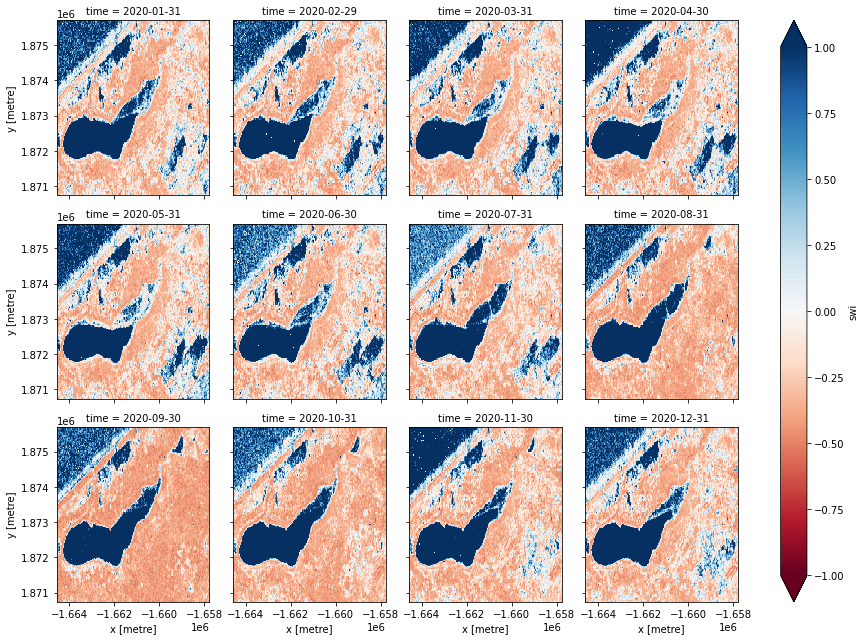

In [21]:
%%time
sample_frequency="1M"  

#resample using medians
print('calculating swi seasonal medians...')
swi = swi['swi'].resample(time=sample_frequency).median().compute()
swi.plot(col='time', col_wrap=4, cmap='RdBu', vmax=1, vmin=-1);

In [22]:
ds_MNDWI = calculate_indices(ds=S2, index='MNDWI', collection='s2', drop=True)
ds_NDWI = calculate_indices(ds=S2, index='NDWI', collection='s2', drop=True)
ds_AWEI = calculate_indices(ds=S2, index='AWEI_sh', collection='s2', drop=True) #Automated Water Extraction Index
ds_WI = calculate_indices(ds=S2, index='WI', collection='s2', drop=True)
    
                       

Dropping bands ['green', 'swir_1', 'nir', 'red', 'blue', 'swir_2']
Dropping bands ['green', 'swir_1', 'nir', 'red', 'blue', 'swir_2']
Dropping bands ['green', 'swir_1', 'nir', 'red', 'blue', 'swir_2']
Dropping bands ['green', 'swir_1', 'nir', 'red', 'blue', 'swir_2']


In [23]:
%%time
sample_frequency="1M"  # quarterly starting in DEC, i.e. seasonalQS-DEC

#resample using medians
print('calculating Water Index seasonal medians...')
Water_Index1 = ds_MNDWI['MNDWI'].resample(time=sample_frequency).median().compute()

calculating Water Index seasonal medians...
CPU times: user 1.6 s, sys: 155 ms, total: 1.76 s
Wall time: 26.6 s


In [24]:
%%time
sample_frequency="1M"  # quarterly starting in DEC, i.e. seasonalQS-DEC

#resample using medians
print('calculating Water Index seasonal medians...')
Water_Index2 = ds_NDWI['NDWI'].resample(time=sample_frequency).median().compute()

calculating Water Index seasonal medians...
CPU times: user 1.51 s, sys: 153 ms, total: 1.66 s
Wall time: 21 s


In [ ]:
%%time
sample_frequency="1M"  # quarterly starting in DEC, i.e. seasonalQS-DEC

#resample using medians
print('calculating Water Index seasonal medians...')
Water_Index3 = ds_AWEI['AWEI_sh'].resample(time=sample_frequency).median().compute()

calculating Water Index seasonal medians...


 # Water Index, Fisher 2016
        "WI": lambda ds:(
            1.7204
            + 171 * ds.green
            + 3 * ds.red
            - 70 * ds.nir
            - 45 * ds.swir_1
            - 71 * ds.swir_2

In [ ]:
%%time
sample_frequency="1M"  # quarterly starting in DEC, i.e. seasonalQS-DEC

#resample using medians
print('calculating Water Index seasonal medians...')
Water_Index4 = ds_WI['WI'].resample(time=sample_frequency).median().compute()

In [ ]:
Water_Index1.plot(col='time', col_wrap=4, cmap='RdBu', vmax=1, vmin=-1);

In [ ]:
Water_Index2.plot(col='time', col_wrap=4, cmap='RdBu', vmax=1, vmin=-1);

In [ ]:
Water_Index3.plot(col='time', col_wrap=4, cmap='RdBu', vmax=1, vmin=-1);

In [ ]:
Water_Index4.plot(col='time', col_wrap=4, cmap='RdBu', vmax=1, vmin=-1);